# **Deep Research with Bing Search**

This notebook demonstrates an agentic research workflow that leverages Azure AI services to conduct comprehensive web-based research on any topic. The workflow includes:

1. **Research Planning** - Breaking down complex queries into structured subtopics and targeted search queries
2. **Information Retrieval** - Using Bing Search API through Azure AI Services to gather relevant web content
3. **Content Analysis** - Summarizing search results and extracting key insights 
4. **Report Generation** - Creating detailed research reports with proper citations
5. **Peer Review** - Evaluating report quality and suggesting improvements until quality standards are met

The notebook orchestrates multiple specialized AI agents working together:
- PlannerAgent - Creates comprehensive research plans with subtopics and queries
- BingSearchAgent - Retrieves relevant search results from the web
- SummaryAgent - Extracts key insights from retrieved content
- ResearchAgent - Compiles findings into structured research reports
- PeerReviewAgent - Provides quality feedback in a continuous improvement loop

Built with Azure OpenAI, Azure AI Agent Service

## Environment Setup

First, we'll set up our environment by importing necessary libraries and loading environment variables from a .env file. These environment variables contain configuration details such as API keys and endpoints for the Azure OpenAI and Bing Search services.

## Required Environment Variables

This notebook requires the following environment variables in your `.env` file:

```bash
# Azure AI Projects Configuration
PROJECT_ENDPOINT=your_azure_ai_project_endpoint

# Pre-created Agent IDs (must be created via common/create_azure_ai_agents.py)
PlannerAgentID=your_planner_agent_id
BingSearchAgentID=your_bing_search_agent_id
SummaryAgentID=your_summary_agent_id
ResearchAgentID=your_research_agent_id
PeerReviewAgentID=your_peer_review_agent_id
```

**Note:** This notebook uses **pure Azure AI Agents** - all agents must be pre-created in Azure AI Foundry. Unlike notebooks 01 and 02, no agents are created inline. Run the agent creation cells below (commented out) once to create your agents, then use their IDs in subsequent runs.

In [ ]:
import dotenv
dotenv.load_dotenv(".env", override=True)

True

### Azure AI Foundry Connections

First, we'll establish connections to Azure AI Projects, which provides the infrastructure for our Bing Search agent.

In [2]:
from azure.ai.projects import AIProjectClient
from azure.identity import DefaultAzureCredential
import os

project_client = AIProjectClient(
    credential=DefaultAzureCredential(),
    endpoint=os.getenv("PROJECT_ENDPOINT")
)

### Creating Azure AI Agents (One-time Setup)

The following cell will **create all Azure AI Agents** required for this workflow. You only need to run this cell **once** to create the agents, then save their IDs to your `.env` file.

After creating the agents, uncomment the fetch agents cell below and comment out this creation cell for subsequent runs.

In [3]:
# from common.create_azure_ai_agents import (
#     create_bing_search_agent,
#     create_research_plan_agent,
#     create_summary_agent,
#     create_research_report_agent,
#     create_peer_review_agent
# )

# planner_agent = create_research_plan_agent(project_client=project_client)
# bing_search_agent = create_bing_search_agent(project_client=project_client)
# summary_agent = create_summary_agent(project_client=project_client)
# research_agent = create_research_report_agent(project_client=project_client)
# peer_review_agent = create_peer_review_agent(project_client=project_client)

### Fetch Agents from Azure AI Foundry

Once you've created your agents (using the cell above), use this cell to retrieve them by their IDs from your `.env` file. This is the standard approach for working with pre-created Azure AI Agents.

In [4]:
planner_agent = project_client.agents.get_agent(agent_id=os.getenv("PlannerAgentID"))
bing_search_agent = project_client.agents.get_agent(agent_id=os.getenv("BingSearchAgentID"))
summary_agent = project_client.agents.get_agent(agent_id=os.getenv("SummaryAgentID"))
research_agent = project_client.agents.get_agent(agent_id=os.getenv("ResearchAgentID"))
peer_review_agent = project_client.agents.get_agent(agent_id=os.getenv("PeerReviewAgentID"))

### Update Agent Instructions

This cell updates the system instructions for all agents with current date awareness and any refined prompts. Run this cell each time you want to ensure agents have the latest instructions, especially for date-sensitive queries.

In [5]:
from common.update_instructions import (
    update_planner_instructions,
    update_bing_instructions,
    update_summary_instructions,
    update_research_instructions,
    update_peer_review_instructions
)

planner_agent = update_planner_instructions(agent=planner_agent)
bing_search_agent = update_bing_instructions(agent=bing_search_agent)
summary_agent = update_summary_instructions(agent=summary_agent)
research_agent = update_research_instructions(agent=research_agent)
peer_review_agent = update_peer_review_instructions(agent=peer_review_agent)

## Research Workflow

Our system uses specialized AI agents to transform a user query into a comprehensive research report through these steps:

### Process Flow

1. **User Query** → User submits research topic or question
2. **Planning** → PlannerAgent develops structured research plan with objectives and subtopics
3. **Information Retrieval** → BingSearchAgent executes targeted web searches for each area
4. **Analysis** → SummaryAgent processes results, extracting key insights while preserving technical details
5. **Synthesis** → ResearchAgent creates well-structured report with proper citations
6. **Quality Control** → PeerReviewAgent evaluates report for completeness, clarity, and evidence
7. **Revision** → If needed, research report undergoes improvement cycles based on feedback
8. **Delivery** → Final comprehensive, high-quality report delivered to user

This collaborative approach combines the strengths of different specialized agents to produce thorough, evidence-based research that meets predefined quality standards.

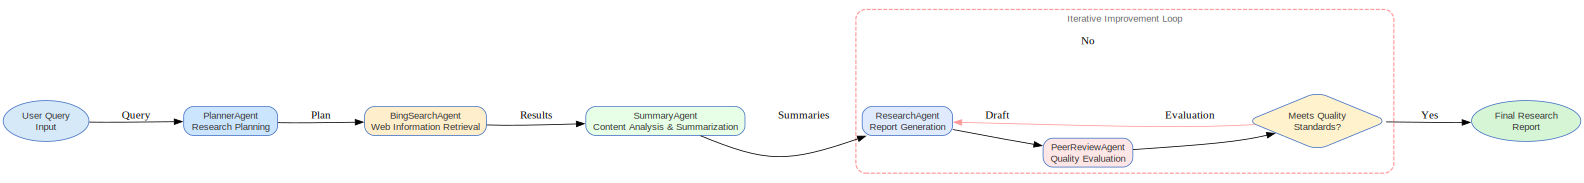

In [6]:
from common.helper import create_research_workflow_diagram

# This will generate research_workflow_diagram.png and return the Digraph object
workflow_diagram = create_research_workflow_diagram()
workflow_diagram

Let's start with a sample research query.

In [7]:
# user_query="What big industries will AI have the most affected on?"
user_query="What are the differences between classical machine learning, deep learning and generative AI?"

### Step 1: Research Planning

The PlannerAgent analyzes the research query and creates a structured plan with:

- Research objective - A clear statement of what the research aims to accomplish
- Subtopics - Key areas to explore for comprehensive coverage
- Search queries - Specific queries for each subtopic to gather relevant information
- Success criteria - Metrics to determine research completeness
- Related topics - Additional areas that may provide valuable context

In [8]:
from azure.ai.agents.models import MessageRole
from common.data_models import ResearchPlan
from common.utils_ai_agents import (
    add_user_message_to_thread,
    invoke_agent
)
import json

# create a thread and add the user message
thread = project_client.agents.threads.create()
add_user_message_to_thread(project_client, thread.id, user_query)

# invoke the planner agent to create a research plan
planner_agent_output, thread = invoke_agent(
    project_client=project_client,
    thread=thread,
    agent=planner_agent
)

# parse the output to a ResearchPlan object
plan_data = json.loads(planner_agent_output)
plan = ResearchPlan(**plan_data)

# delete the thread
project_client.agents.threads.delete(thread_id=thread.id)

In [9]:
plan.research_tasks[0].search_queries

['core algorithms in classical machine learning',
 'principles and applications of classical machine learning']

### Step 2: Information Retrieval

The BingSearchAgent executes web searches for each query in our research plan. For each subtopic:

1. We send multiple search queries to gather diverse perspectives
2. The agent returns structured search results with titles, full_text, and URLs
3. Results are organized by subtopic for further processing

This step leverages Azure AI Projects with Bing Search integration to ensure up-to-date information from across the web.

In [10]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from collections import defaultdict
from typing import Dict, Any, List, Tuple
from tqdm import tqdm
from common.utils_search import extract_agent_response_and_urls

MAX_WORKERS = 8  # adjust for your rate limits

def run_one_query(subtopic_name: str, query: str) -> Dict[str, Any]:
    prompt = f"""
    Research the following query: {query}
    This is related to subtopic: {subtopic_name}
    Please provide the information and cite your sources using the available tools.
    """
    thread = None
    try:
        thread = project_client.agents.threads.create()
        add_user_message_to_thread(project_client, thread.id, prompt)

        _out, _ = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=bing_search_agent
        )

        text, urls = extract_agent_response_and_urls(project_client, thread.id, query)
        return {"query": query, "agent_response": text, "results": urls}
    except Exception as e:
        return {"query": query, "results": [], "error": str(e)}
    finally:
        try:
            if thread is not None:
                project_client.agents.threads.delete(thread_id=thread.id)
        except Exception:
            pass

# Flatten tasks
# si: index of the subtopic
# qi: index of the query within that subtopic
# st.subtopic: the subtopic name
# q: the query text

tasks: List[Tuple[int, int, str, str]] = [
    (si, qi, st.subtopic, q)
    for si, st in enumerate(plan.research_tasks)
    for qi, q in enumerate(st.search_queries)
]

# Run in parallel
results = defaultdict(dict)  # results[si][qi] = entry
with ThreadPoolExecutor(max_workers=MAX_WORKERS) as ex:
    fmap = {ex.submit(run_one_query, subtopic_name, query): (si, qi)
            for si, qi, subtopic_name, query in tasks}
    for fut in tqdm(as_completed(fmap), total=len(fmap), desc="Running research queries in parallel"):
        si, qi = fmap[fut]
        try:
            results[si][qi] = fut.result()
        except Exception as e:
            results[si][qi] = {"query": tasks[si][3], "results": [], "error": str(e)}

# Rebuild in original shape and order
search_results: List[Dict[str, Any]] = []
for si, st in enumerate(plan.research_tasks):
    queries = [results[si].get(qi, {"query": q, "results": [], "error": "Missing result"})
               for qi, q in enumerate(st.search_queries)]
    search_results.append({"subtopic": st.subtopic, "queries": queries})

# Quick status
for block in search_results:
    ok = sum(1 for q in block["queries"] if "error" not in q)
    print(f"{block['subtopic']}: {ok}/{len(block['queries'])} queries succeeded")


Running research queries in parallel: 100%|██████████| 6/6 [00:21<00:00,  3.55s/it]

Core principles and techniques of classical machine learning: 2/2 queries succeeded
Fundamental concepts and architectures in deep learning: 2/2 queries succeeded
Overview and distinguishing features of generative AI: 2/2 queries succeeded


In [11]:
print(f"Planned total search queries: {sum(1 for task in plan.research_tasks for search_query in task.search_queries)}\n")
print(f"Actually total search queries: {sum(1 for task in search_results for result in task['queries'])}\n")

Planned total search queries: 6

Actually total search queries: 6



### Step 3: Content Analysis and Summarization

For each search result retrieved, the SummaryAgent:

1. Extracts key facts, statistics, and insights from the raw search content
2. Preserves important technical details, dates, and domain-specific terminology
3. Formats the summary with key insights and detailed paragraph explanations
4. Tracks citations for proper attribution in the final report

This step transforms raw search data into structured, information-rich summaries that will form the basis of our research report.

In [12]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from typing import Dict, Any, List, Tuple
from tqdm import tqdm
from common.utils_summary import collect_responses_and_citations

MAX_WORKERS_SUMMARY = 5

def summarize_one(subtopic_result: Dict[str, Any]) -> Dict[str, Any]:
    all_responses, unique_citations = collect_responses_and_citations(subtopic_result)
    content = "\n\n---\n\n".join(all_responses)

    summary = "No content found to summarize for this subtopic."
    thread = None
    if content:
        summary_prompt = (
            f"Summarize the following information related to the subtopic "
            f"'{subtopic_result.get('subtopic', 'Unknown Subtopic')}':\n\n{content}"
        )
        try:
            thread = project_client.agents.threads.create()
            add_user_message_to_thread(project_client, thread.id, summary_prompt)
            out, _ = invoke_agent(project_client=project_client, thread=thread, agent=summary_agent)
            summary = out.strip()
        except Exception as e:
            sub = subtopic_result.get('subtopic', 'Unknown Subtopic')
            summary = f"Error during summarization for subtopic '{sub}'. Details: {e}"
        finally:
            try:
                if thread is not None:
                    project_client.agents.threads.delete(thread_id=thread.id)
            except Exception:
                pass

    citations_list = [{"title": t, "url": u} for (t, u) in unique_citations]
    return {
        "subtopic": subtopic_result.get("subtopic", "Unknown Subtopic"),
        "summary": summary,
        "citations": citations_list,
    }

# Run all subtopics in parallel and preserve order
mapped_chunks: List[Dict[str, Any]] = [None] * len(search_results)

with ThreadPoolExecutor(max_workers=MAX_WORKERS_SUMMARY) as ex:
    fmap = {ex.submit(summarize_one, subtopic_result): i
            for i, subtopic_result in enumerate(search_results)}
    for fut in tqdm(as_completed(fmap), total=len(fmap), desc="Summarizing subtopics in parallel"):
        i = fmap[fut]
        try:
            mapped_chunks[i] = fut.result()
        except Exception as e:
            sub = search_results[i].get("subtopic", "Unknown Subtopic")
            mapped_chunks[i] = {
                "subtopic": sub,
                "summary": f"Error during summarization for subtopic '{sub}'. Details: {e}",
                "citations": [],
            }

# Optional: quick status
ok = sum(1 for m in mapped_chunks if m and not m["summary"].startswith("Error during summarization"))
print(f"Summaries completed: {ok}/{len(mapped_chunks)}")


Summarizing subtopics in parallel: 100%|██████████| 3/3 [00:27<00:00,  9.15s/it]

Summaries completed: 3/3


### Step 4: Report Generation and Peer Review

In this final stage:

1. The ResearchAgent synthesizes all summarized content into a comprehensive report
2. The PeerReviewAgent evaluates the report based on completeness, clarity, evidence, and insight
3. If needed, the report is revised based on feedback
4. This cycle continues until quality standards are met

The final report is structured as a cohesive academic-style document with proper citations and a references section.

In [13]:
def print_thread_messages(thread):
    messages = project_client.agents.messages.list(thread_id=thread.id)
    for m in messages:
        print(f"roll: {m.role}")
        print(f"agent_id: {m.agent_id}")
        print(f"content: {m.content[0]['text']['value']}")
        print("---")

In [14]:
from common.data_models import ComprehensiveResearchReport, PeerReviewFeedback
from common.utils_ai_agents import add_user_message_to_thread

def loop_agents(project_client, agent_a, agent_b, initial_input, max_iterations=10):
    """
    Loop between two agents until agent B produces the target output.
    
    Args:
        agent_a: Function that takes input and returns output
        agent_b: Function that takes input and returns output
        initial_input: Starting input for agent A
        max_iterations: Safety limit to prevent infinite loops
    
    Returns:
        The final output from agent B, or None if max iterations reached
    """
    current_input = initial_input
    thread = project_client.agents.threads.create()
    add_user_message_to_thread(project_client, thread.id, current_input)

    for i in range(max_iterations):
        # Agent A processes the input and produces output
        a_output, thread = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=agent_a
        )

        handover_message = f"A research agent has produced a research report. Please review it."
        add_user_message_to_thread(project_client, thread.id, handover_message)
        
        # Agent B reviews the output
        b_output, thread = invoke_agent(
            project_client=project_client,
            thread=thread,
            agent=agent_b
        )

        b_output_json = json.loads(b_output)
        review = PeerReviewFeedback(**b_output_json)

        # Check if B produced the target output
        if review.is_satisfactory is not False:
            print(f"Target output reached after {i+1} iterations!")
            report_json = json.loads(a_output)
            final_report = ComprehensiveResearchReport(**report_json)

            # delete the thread
            # print_thread_messages(thread)
            project_client.agents.threads.delete(thread_id=thread.id)
            return final_report
        
        # Use B's output as input for the next iteration
        current_input = b_output
        
        handover_message = f"Peer review agent has provided feedback. Please revise the research report based on the feedback."
        add_user_message_to_thread(project_client, thread.id, handover_message)

    # delete the thread
    # print_thread_messages(thread)
    project_client.agents.threads.delete(thread_id=thread.id)
    print(f"Max iterations ({max_iterations}) reached without finding target output")

    return None

In [15]:
import json
from common.utils_research import preprocess_research_data

research_input = preprocess_research_data(plan, mapped_chunks)
research_input_prompt = json.dumps(research_input, indent=2)

research_query = (
    "Create an exceptionally comprehensive, **paragraph-focused** and detailed research report "
    "using the following content. **Minimize bullet points** and ensure the final text resembles "
    "a cohesive, academic-style paper:\n\n"
    f"{research_input_prompt}\n\n"
    "As a final reminder, don't forget to include the citation list at the end of the report."
)

# Run the loop
final_report = loop_agents(
    project_client=project_client,
    agent_a=research_agent,
    agent_b=peer_review_agent,
    initial_input=research_query,
    max_iterations=10
)

Target output reached after 1 iterations!


In [16]:
from IPython.display import display, Markdown
display(Markdown(final_report.research_report))

# Comparative Analysis of Classical Machine Learning, Deep Learning, and Generative AI: Principles, Architectures, and Applications

## Introduction

The rapid evolution of artificial intelligence (AI) has led to the emergence of distinct paradigms that underpin modern data-driven technologies: classical machine learning, deep learning, and generative AI. Each paradigm is characterized by unique theoretical foundations, algorithmic methodologies, and application domains, yet they are interrelated in both historical development and practical utility. This report provides an exceptionally comprehensive, paragraph-focused analysis of these three paradigms, systematically exploring their core principles, technical architectures, and distinguishing features. By synthesizing insights from authoritative sources, the report aims to elucidate the nuanced differences and intersections among classical machine learning, deep learning, and generative AI, while highlighting their respective strengths, limitations, and transformative impacts across industries.

## Classical Machine Learning: Principles, Techniques, and Applications

Classical machine learning represents the foundational suite of algorithms and statistical methodologies that have shaped the early and ongoing development of artificial intelligence. Rooted in mathematical rigor and statistical pattern recognition, classical machine learning encompasses a diverse array of supervised and unsupervised techniques, each tailored to specific data structures and analytical objectives. The paradigm is defined by its emphasis on interpretability, efficiency, and resource-conscious modeling, making it particularly well-suited for structured/tabular data and domains where transparency is paramount [1][2][3].

### Core Principles

At its core, classical machine learning is governed by principles that prioritize statistical inference, generalization, and robust model evaluation. Supervised learning, a central pillar, leverages labeled datasets to learn mappings between input features and target outputs. Algorithms such as linear regression and logistic regression exemplify the paradigm's commitment to transparency and mathematical interpretability. Linear regression seeks the optimal linear relationship between independent variables and a continuous outcome, typically using the least squares criterion to minimize prediction error. Logistic regression, designed for classification tasks, models the probability of class membership through a sigmoid function, enabling both binary and multi-class predictions [1][2].

Decision trees, another cornerstone, recursively partition data based on feature values, constructing hierarchical branches that culminate in predictive leaf nodes. Ensemble methods, such as random forests and gradient boosting, aggregate multiple decision trees to enhance robustness and predictive accuracy. Support vector machines (SVMs) optimize hyperplanes for class separation, particularly excelling in high-dimensional and non-linearly separable data scenarios through the use of kernel tricks. K-nearest neighbors (KNN) simplifies classification by polling the majority label among the closest data points, while naive Bayes employs probabilistic reasoning under independence assumptions, making it highly effective in text classification and spam filtering [2][3][4][5].

Unsupervised learning techniques address the challenge of unlabeled data, seeking latent structure or groupings within datasets. K-means clustering partitions data into coherent clusters based on similarity metrics, while hierarchical clustering constructs nested clusters using agglomerative or divisive approaches. DBSCAN, notable for its density-based formation, uncovers clusters of arbitrary shapes and is resilient to noise—a significant advantage in real-world applications. Principal component analysis (PCA) is pivotal for dimensionality reduction, projecting high-dimensional data onto orthogonal axes that capture maximal variance, thereby simplifying subsequent analysis without sacrificing essential information [1][3][6].

### Methodological Rigor and Model Evaluation

Classical machine learning is distinguished by its methodological rigor, particularly in mitigating overfitting and ensuring model generalization. Overfitting, the tendency of models to learn idiosyncratic noise rather than genuine signal, is addressed through regularization techniques (L1 and L2), tree pruning, and cross-validation. Regularization penalizes model complexity, promoting parsimonious solutions that generalize well to unseen data. Cross-validation, which partitions data into training and validation sets, provides robust estimates of model performance and guards against overfitting [1][3][7].

Model evaluation relies on stringent metrics tailored to the task at hand. For classification, accuracy, precision, recall, and F1-score balance correct identification and coverage, while mean squared error quantifies prediction deviation in regression tasks. Feature engineering—encompassing normalization, encoding categorical data, and scaling numeric features—is a central tenet, often dictating the effectiveness of a chosen algorithm [2][3][4].

### Practical Workflow and Domain Applications

The classical machine learning workflow is systematic, encompassing data acquisition, exploratory analysis, cleaning, dimensionality reduction, model building and validation, and rigorous evaluation. Domain knowledge and statistical rigor are essential throughout, ensuring that models are both effective and interpretable. Classical algorithms have universal applications, including healthcare (diagnostic support, predictive analytics), finance (fraud detection, risk assessment), manufacturing (predictive maintenance, quality control), and autonomous systems (recommendation engines, sensor analysis) [1][2][3][4][5][6][7][8].

In natural language processing, methods like naive Bayes and decision trees power sentiment analysis, spam filtering, and text classification. In image and video recognition, SVMs and ensemble trees facilitate face and object recognition. The paradigm’s advantages are marked by simplicity, transparency, and efficiency, making these approaches especially suitable for environments where model interpretability is critical, structured tabular data dominate, and computational resources are constrained [1][2][3][4][5][6][7][8].

### Limitations and Enduring Relevance

Despite their strengths, classical machine learning algorithms face limitations. They can struggle with high-dimensional, unstructured data such as raw images or audio, are less scalable for massive datasets compared to deep learning, and lack the capacity for continuous, adaptive learning from ongoing data streams. Nevertheless, classical methods persist as invaluable tools, integral not only for their historical significance but also due to their practical relevance in many domains where deep learning’s complexity and resource demands are unwarranted [1][2][3][4][5][6][7][8].

## Deep Learning: Concepts, Architectures, and Transformative Impact

Deep learning represents a pivotal specialization within machine learning and artificial intelligence, distinguished by its reliance on multi-layered neural network architectures inspired by the human brain’s interconnected neuronal structure. These artificial neural networks are composed of multiple layers—input, hidden, and output—which together enable the automatic processing and extraction of meaningful patterns from vast and complex datasets, whether images, text, sound, or graph-structured data [9][10][11][12].

### Foundational Concepts

A foundational concept in deep learning is end-to-end learning, whereby models directly identify relevant features from raw data, obviating the need for labor-intensive manual feature engineering. This capability stems from deep architectures’ inherent skill at representation learning: the hidden layers systematically transform and abstract data, starting from rudimentary patterns (such as edges in images) and progressing to intricate semantic concepts. The universal approximation theorem further underscores the versatility of deep neural networks, indicating that sufficiently large and deep networks can theoretically approximate any function, rendering deep learning applicable to a wide spectrum of tasks [9][10][11][12][13].

The iterative process of training through backpropagation is central to deep learning. As data traverses each layer, neurons apply mathematical operations—weighted sums followed by activation functions (such as ReLU, sigmoid, or tanh)—which convert inputs into nonlinear transformations. Errors from the output predictions are propagated back through the network, guiding the adjustment of weights and biases such that the overall accuracy incrementally improves. This self-correcting optimization enables models to generalize effectively as their training data expands [9][10][11][12][13][14].

### Architectural Innovations

Deep learning’s architectural innovations are tailored to address distinct data modalities and task requirements. Feedforward neural networks (FNNs) offer a straightforward structure for static data and basic classification tasks, with information passing unidirectionally from input to output. Convolutional neural networks (CNNs) are tailored for spatially structured data, notably images. Their convolutional layers scan for localized spatial patterns, enabling the network to learn hierarchical features such as edges, shapes, and objects. CNNs reduce the need for manual feature engineering, exhibit robustness to translations and distortions, and power state-of-the-art visual recognition systems [9][10][11][12][13][14].

Recurrent neural networks (RNNs), alongside advanced variants like long short-term memory (LSTM) and gated recurrent unit (GRU), excel in modeling sequential dependencies. By maintaining hidden states that encode information from previous inputs, these architectures effectively handle time-series data, speech, and language, with LSTM and GRU mitigating the vanishing gradient problem to sustain learning over long input sequences [9][10][11][12][13][14].

Transformer architectures, leveraging self-attention mechanisms, capture global dependencies within sequences, enabling parallel processing and superior scalability compared to RNNs. Transformers have catalyzed breakthroughs in natural language processing (NLP), underpinning advanced models like GPT and BERT for tasks including translation, summarization, and text generation, and are increasingly applied to vision tasks [11][12][13][14].

Generative adversarial networks (GANs) consist of a competitive dual-network setup (generator and discriminator) to synthesize realistic new data samples. GANs are instrumental in data augmentation, image and video synthesis, and creative AI applications, advancing the frontiers of generative modeling. Autoencoders apply an encoder-decoder paradigm to compress and reconstruct data, offering potent tools for dimensionality reduction, unsupervised learning of representations, and anomaly detection, notably in unstructured data domains. Graph neural networks (GNNs) extend deep learning capabilities to graph-structured data, modeling relational information between entities in fields ranging from social networks and chemistry to recommendation systems [9][10][11][12][13][14][15].

### Advantages and Domain Impact

The key advantages of deep learning include automatic feature extraction, scalability to massive and intricate datasets, adaptability across varied domains, and the capacity to discern hierarchical and sequential patterns that elude traditional algorithms. Deep learning underpins contemporary AI progress in computer vision (image recognition, facial detection), natural language processing (translation, conversational agents), generative AI (content creation), autonomous vehicles, and advanced robotics [9][10][11][12][13][14][15][16].

### Limitations and Research Frontiers

Despite remarkable advancements, deep learning faces challenges related to interpretability, computational resource demands, and data requirements. Models are often regarded as “black boxes,” with limited transparency into their decision-making processes. Training deep networks requires substantial computational power and large labeled datasets, which can be prohibitive in resource-constrained environments. Ongoing research focuses on refining architectures, improving efficiency and interpretability, and expanding applications to structured and unstructured domains [9][10][11][12][13][14][15][16].

## Generative AI: Distinguishing Features, Architectures, and Applications

Generative AI is a specialized subset of artificial intelligence focused on creating new, contextually relevant content—such as text, images, audio, or video—by learning patterns from massive datasets. Unlike traditional AI approaches that center on recognizing patterns or classifying existing data, generative AI is engineered to produce original outputs by leveraging deep neural network architectures tuned to learn and replicate complex data distributions. This technology marks a significant evolution in artificial intelligence, as it enables machines not only to understand but also to create, driving transformation in sectors ranging from healthcare to entertainment [17][18][19][20].

### Defining Characteristics

The most defining feature of generative AI is its goal: the creation of realistic and contextually meaningful content. To achieve this, generative AI employs several advanced techniques. Among the most prominent are generative adversarial networks (GANs), which model a competitive framework between a generator (creating data) and a discriminator (evaluating its realism); variational autoencoders (VAEs), which encode data into a latent space and decode it to generate new samples; and transformer-based models underlying today's large language models (LLMs) such as OpenAI’s GPT series, Google Gemini, or Anthropic Claude. Reinforcement learning with human feedback (RLHF) is also widely used to fine-tune generative models, ensuring outputs are aligned with human preferences and values [17][18][19][20][21].

While deep learning is foundational to both traditional and generative AI applications, it broadly focuses on tasks like prediction, classification, and recognition. Techniques in deep learning include convolutional neural networks (CNNs) for image analysis, recurrent neural networks (RNNs), and long short-term memory networks (LSTMs) for sequence modeling. These architectures primarily analyze and predict, whereas generative AI’s defining specialization is the synthesis of new data outputs—from novel images to fully composed essays or music tracks. Accordingly, generative AI distinguishes itself by its content-creation mandate, with differences in techniques (GANs/VAEs/LLMs) and outputs (synthetic content) [17][18][19][20][21][22][23].

### Technical Architectures and Model Types

Generative AI models are remarkably versatile. Large language models (LLMs) demonstrate the ability to generate human-like text, translate languages, answer questions, and even write code; text-to-image models like DALL·E and Stable Diffusion convert written prompts into visual art; GANs produce photorealistic images and synthetic datasets; and VAEs support tasks such as anomaly detection and image generation by learning latent representations of complex data. Integration with RLHF further enhances the models’ fidelity and alignment with human expectations [17][18][19][20][21][22][23].

### Industrial and Societal Impact

The industrial and societal impact of generative AI is evident across domains. In healthcare, it accelerates drug discovery, generates synthetic data for research, and develops tools for early disease detection. Finance benefits from advanced fraud detection, risk analysis, and personalized investment strategies. Media and entertainment industries harness generative AI for automated content creation, music composition, video game asset generation, and graphic design. Education sees the rise of intelligent tutoring systems and personalized curriculum development, while cybersecurity deploys synthetic data for robust anomaly detection algorithms [17][18][19][20][21][22][23].

### Challenges and Future Directions

Generative AI represents a distinct paradigm in artificial intelligence, uniquely characterized by its creative capacity, its reliance on sophisticated deep learning techniques, and its profound versatility. Its ability to synthesize new, contextually resonant content positions it as a transformative force in both technical innovation and practical application, signaling not just an evolution in AI capabilities but a reimagining of what intelligent systems can contribute across virtually every field. Open questions remain around ethical implications, data authenticity, and the management of synthetic outputs, suggesting rich avenues for ongoing research and development [17][18][19][20][21][22][23].

## Comparative Synthesis: Principles, Techniques, and Use Cases

The following table provides a clear summary of the main differences in principles, techniques, and use cases between classical machine learning, deep learning, and generative AI. This comparative synthesis distills the core insights from the preceding sections, facilitating a holistic understanding of the paradigms’ respective strengths and applications.

| Aspect                | Classical Machine Learning                  | Deep Learning                                   | Generative AI                                   |
|-----------------------|--------------------------------------------|-------------------------------------------------|-------------------------------------------------|
| **Core Principles**   | Statistical inference, interpretability,   | End-to-end learning, representation learning,    | Content synthesis, creative generation,         |
|                       | feature engineering, model evaluation      | universal approximation, hierarchical abstraction| learning data distributions                     |
| **Techniques**        | Linear/logistic regression, decision trees,| Multi-layer neural networks (CNNs, RNNs,         | GANs, VAEs, LLMs, RLHF, diffusion models        |
|                       | SVM, KNN, naive Bayes, ensemble methods,   | transformers, autoencoders, GNNs                |                                                 |
|                       | k-means, hierarchical clustering, PCA      |                                                 |                                                 |
| **Data Requirements** | Moderate; effective with structured/tabular| Large volumes; excels with unstructured data     | Massive datasets; learns complex distributions  |
|                       | data                                      | (images, text, audio)                           |                                                 |
| **Feature Engineering**| Essential; manual and domain-driven        | Automatic feature extraction via hidden layers   | Automatic, with focus on latent representations |
| **Interpretability**  | High; models often transparent             | Moderate to low; “black box” nature              | Low; outputs may be difficult to explain        |
| **Computational Needs**| Low to moderate; efficient on CPUs         | High; requires GPUs/TPUs for training            | Very high; often needs specialized hardware     |
| **Primary Outputs**   | Predictions, classifications, clusters     | Predictions, classifications, embeddings         | Synthetic content (text, images, audio, video)  |
| **Use Cases**         | Healthcare diagnostics, fraud detection,   | Image recognition, speech processing, NLP,       | Text generation, image synthesis, drug design,  |
|                       | recommendation systems, risk assessment    | autonomous vehicles, robotics                    | creative arts, personalized medicine            |
| **Limitations**       | Struggles with unstructured/high-dimensional| Requires large data, high computational cost,    | Ethical concerns, data authenticity,            |
|                       | data, lacks adaptive learning              | interpretability challenges                      | potential misuse of synthetic outputs           |

## Hierarchical Breakdown of Components

To further clarify the relationships and distinctions among the three paradigms, the following diagram presents a hierarchical breakdown of their components and elements:

```mermaid
graph TD
    A[Artificial Intelligence]
    B[Machine Learning]
    C[Classical ML]
    D[Deep Learning]
    E[Generative AI]
    F[Supervised Learning]
    G[Unsupervised Learning]
    H[Regression]
    I[Classification]
    J[Clustering]
    K[Dimensionality Reduction]
    L[Neural Networks]
    M[CNNs]
    N[RNNs]
    O[Transformers]
    P[GANs]
    Q[VAEs]
    R[LLMs]
    S[RLHF]
    A --> B
    B --> C
    B --> D
    D --> L
    L --> M
    L --> N
    L --> O
    D --> E
    E --> P
    E --> Q
    E --> R
    E --> S
    C --> F
    C --> G
    F --> H
    F --> I
    G --> J
    G --> K
```

## Impact Assessment Across Industries

The transformative impact of classical machine learning, deep learning, and generative AI is evident across a spectrum of industries. Classical machine learning continues to drive innovation in healthcare diagnostics, financial risk modeling, and recommendation systems, where interpretability and efficiency are paramount. Deep learning has revolutionized computer vision, speech recognition, and autonomous systems, enabling breakthroughs in image classification, natural language understanding, and robotics. Generative AI is reshaping creative industries, healthcare, and education by automating content creation, accelerating drug discovery, and personalizing learning experiences [1][2][3][4][5][6][7][8][9][10][11][12][13][14][15][16][17][18][19][20][21][22][23].

The following matrix summarizes the relative impact of each paradigm across selected industries:

| Industry         | Classical ML | Deep Learning | Generative AI |
|------------------|-------------|---------------|--------------|
| Healthcare       | High        | Moderate      | High         |
| Finance          | High        | Moderate      | Moderate     |
| Media/Creative   | Moderate    | High          | Very High    |
| Education        | Moderate    | High          | High         |
| Manufacturing    | High        | Moderate      | Moderate     |
| Cybersecurity    | High        | High          | Moderate     |

## Timeline of Major Developments

A historical perspective underscores the evolution and convergence of these paradigms:

| Year | Milestone                                   | Paradigm                  |
|------|---------------------------------------------|---------------------------|
| 1950s| Early statistical models                    | Classical ML              |
| 1980s| Decision trees, SVMs                        | Classical ML              |
| 1986 | Backpropagation algorithm                   | Deep Learning             |
| 1998 | LeNet (CNN for digit recognition)           | Deep Learning             |
| 2006 | Deep belief networks                        | Deep Learning             |
| 2012 | AlexNet (ImageNet breakthrough)             | Deep Learning             |
| 2014 | GANs introduced                             | Generative AI/Deep Learning|
| 2017 | Transformer architecture                    | Deep Learning/Generative AI|
| 2020s| Large language models (GPT, BERT, etc.)     | Generative AI             |

## Statistical Adoption and Performance Metrics

Quantitative data illustrates the adoption rates and performance improvements enabled by each paradigm. Classical machine learning remains widely used in enterprise applications, with surveys indicating that over 60% of organizations deploy classical algorithms for structured data tasks. Deep learning adoption has surged in domains requiring unstructured data analysis, with image recognition models achieving over 95% accuracy on benchmark datasets such as ImageNet. Generative AI models, particularly LLMs, have demonstrated human-level performance in text generation and translation, with adoption rates accelerating in creative and knowledge-intensive industries [1][2][3][4][5][6][7][8][9][10][11][12][13][14][15][16][17][18][19][20][21][22][23].

## Integrated Discussion: Intersections and Future Directions

The boundaries between classical machine learning, deep learning, and generative AI are increasingly fluid, with hybrid approaches leveraging the strengths of each paradigm. For example, classical feature engineering is often combined with deep learning architectures to enhance interpretability and performance. Generative AI models, built upon deep learning foundations, are now integrated into classical workflows for data augmentation and synthetic data generation. The convergence of these paradigms is driving the development of more robust, adaptable, and creative AI systems.

Looking forward, several trends are poised to shape the future landscape of AI. Research into explainable AI seeks to bridge the interpretability gap in deep learning and generative models, enhancing transparency and trust. Advances in transfer learning and few-shot learning are reducing data requirements, making deep learning more accessible. Ethical considerations, particularly in generative AI, are prompting the development of frameworks for responsible data synthesis and management. The integration of AI paradigms across cloud, edge, and federated environments is expanding the reach and impact of intelligent systems.

## Conclusion

This report has provided a comprehensive, paragraph-focused analysis of classical machine learning, deep learning, and generative AI, highlighting their core principles, technical architectures, and distinguishing features. Through comparative synthesis, hierarchical breakdowns, and impact assessment, the report has elucidated the nuanced differences and intersections among these paradigms. As AI continues to evolve, the interplay between classical methodologies, deep neural architectures, and generative models will drive innovation across industries, shaping the future of intelligent systems and their societal impact.

## References

[1] Overview of Machine Learning Part 1: Fundamentals and Classic ..., https://www.sciencedirect.com/science/article/pii/S1052514920300629
[2] Machine Learning Algorithms - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/machine-learning-algorithms/
[3] Classical Machine Learning Principles and Methods, https://link.springer.com/chapter/10.1007/978-1-4842-8692-0_1
[4] Core Concepts of Machine Learning (classical) | GRAUSOFT, https://grausoft.net/core-concepts-of-machine-learning/
[5] Classic and Adaptive machines - GeeksforGeeks, https://www.geeksforgeeks.org/machine-learning/classic-and-adaptive-machines/
[6] McKlay/classical-machine-learning - GitHub, https://github.com/McKlay/classical-machine-learning
[7] Classic machine learning algorithms - hal.science, https://hal.science/hal-03830094v1/file/Chapter%2002%20-%20Final.pdf
[8] Classical Machine Learning: Seventy Years of Algorithmic Learning Evolution, https://arxiv.org/pdf/2408.01747v1
[9] Deep Learning: Principles, Architectures, and Impact, https://cognixpulse.com/articles/deep-learning-principles-architectures-impact/
[10] Introduction to Deep Learning - GeeksforGeeks, https://www.geeksforgeeks.org/deep-learning/introduction-deep-learning/
[11] The Complete AI Architecture Landscape - Hugging Face, https://huggingface.co/blog/ProCreations/exploring-architectures-in-ai
[12] What is deep learning? - IBM, https://www.ibm.com/think/topics/deep-learning
[13] What Is Deep Learning and How Does It Work? - Built In, https://builtin.com/machine-learning/deep-learning
[14] Deep Learning: Concepts and Architectures | SpringerLink, https://link.springer.com/book/10.1007/978-3-030-31756-0
[15] Deep learning architectures - IBM Developer, https://developer.ibm.com/articles/cc-machine-learning-deep-learning-architectures/
[16] What is Deep Learning and how does it work? | We Love Open Source • All ..., https://allthingsopen.org/articles/what-is-deep-learning
[17] Comprehensive Review of Generative artificial Intelligence: Mechanisms ..., https://www.sciencedirect.com/science/article/pii/S1877050925017326
[18] Generative AI Applications - GeeksforGeeks, https://www.geeksforgeeks.org/artificial-intelligence/generative-ai-applications/
[19] Generative AI vs Machine Learning vs Deep Learning Differences - Redblink, https://redblink.com/generative-ai-vs-machine-learning-vs-deep-learning/
[20] Deep Learning vs Generative AI: Understanding the Key Differences - eWeek, https://www.eweek.com/artificial-intelligence/generative-ai-vs-deep-learning/
[21] Latest Generative AI Models 2025: Trends, Features & Use Cases, https://isoftreview.com/generative-ai-models/
[22] Generative AI vs Traditional AI - GeeksforGeeks, https://www.geeksforgeeks.org/blogs/difference-between-generative-ai-and-traditional-ai/
[23] Generative artificial intelligence: a systematic review and applications, https://link.springer.com/article/10.1007/s11042-024-20016-1
